

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

    1.Сколько у нас пользователей, которые совершили покупку только один раз? 

    2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

    3.По каждому товару определить, в какой день недели товар чаще всего покупается.

    4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

    5.Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

    6.Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%matplotlib inline

## Посмотрим на данные

In [2]:
customers = pd.read_csv('/home/oleg/Downloads/karpov_courses-main/\
Промежуточный проект/datasets/olist_customers_dataset.csv')
order_items = pd.read_csv('/home/oleg/Downloads/karpov_courses-main/\
Промежуточный проект/datasets/olist_order_items_dataset.csv')
orders = pd.read_csv('/home/oleg/Downloads/karpov_courses-main/\
Промежуточный проект/datasets/olist_orders_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
customers['customer_id'].nunique()

99441

In [7]:
customers['customer_unique_id'].nunique()

96096

In [8]:
customers['customer_id'].value_counts()

06b8999e2fba1a1fbc88172c00ba8bc7    1
c023f30c1147aeb0358474f3b1dbc707    1
b5cbf43f42281920a175fc99650c91d6    1
19f4e983f8f05b7de16670f8a0cf0ac7    1
229ac14c6ee6d6a606264ebcc861beb7    1
                                   ..
31665bd5bc542687ab54c9fd9ed9917b    1
37fb9cce079a4887c96b59bae2011d05    1
1d815f3ad9b2017b6da2c4f1cbb1180b    1
6b05c8f3a25a71005d5eb9b51766c333    1
274fa6071e5e17fe303b9748641082c8    1
Name: customer_id, Length: 99441, dtype: int64

In [9]:
customers['customer_unique_id'].value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
081f07439678af2da7755a0aa572154d     1
9c57789a6a587f4efcfb01e36c106014     1
9e4c21635f640562de1a6976374fba03     1
06c0ea6ee892364d1608ee47aa9f56a0     1
84732c5050c01db9b23e19ba39899398     1
Name: customer_unique_id, Length: 96096, dtype: int64

Количество уникальных id (customer_unique_id) не совпадает с их общим количесвтом (customer_id), это говорит о том,
что одному уникальному id может соотвествовать несколько обычных. Из этого можно сделать вывод, что количесвто
уникальных покупателей равно количеству количеству уникальных id. В данном случае 96 096.

# 1.Сколько у нас пользователей, которые совершили покупку только один раз?

## Что считать покупкой?

In [10]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Покупкой будем считать заказ, по которому совершена оплата и он доставленидо покупателя.
Этим критериям соответсвует заказ со статусом 'delivered' т.к. в этом случае покупатель получает продукт в руки.
Статус 'shipped' не гарантирует получение товара покупателем (например, потеря товара во время доставки).
Остальные статусы не подходят, так как в них либо отсутсвтует факт оплаты, либо они не доставлены до покупателя.

При подсчете пользователей, которые совершили покупку только один раз, будем учитывать только уникальных пользователей.

In [11]:
delivered_orders = orders.loc[orders['order_status'] == 'delivered']
delivered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [12]:
delivered_orders.shape[0]

96478

In [13]:
customers_orders = delivered_orders.merge(customers, on='customer_id')
customers_orders = customers_orders[['order_id', 'customer_id', 'customer_unique_id', 'order_status']]
customers_orders.head()

,order_id,customer_id,customer_unique_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,delivered


In [14]:
customers_orders.customer_unique_id.value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    15
3e43e6105506432c953e165fb2acf44c     9
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
cca180c80d52d242fca3ed8cfcefad09     1
b4d20e099c1aadc325ac4b8bdb309cd6     1
3ed4235d521c24fec4f77d4254e070b8     1
11a70f262b8ebca18b88fcb5a5f6882b     1
60350aa974b26ff12caad89e55993bd6     1
Name: customer_unique_id, Length: 93358, dtype: int64

Видно что некоторые пользователи совершили более одной покупки. Выберем только тех, кто совершил одну покупку.

In [15]:
num_of_orders = customers_orders\
    .groupby('customer_unique_id', as_index=False)\
    .agg(num_of_purchases=('order_id', 'count'))\
    .query('num_of_purchases == 1')

print(f'{num_of_orders.shape[0]} пользователей, которые совершили покупку только один раз.')

90557 пользователей, которые совершили покупку только один раз.


# 2.Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

Отфильтруем данные

Заказ со статусом 'deliveerd' не подходит, т.к. он доставлен до потребителя. Исключим его.

In [16]:
monthly = orders.loc[orders['order_status'] != 'delivered']
monthly.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


Посмотрим, заказы с какими статусами остались.

In [17]:
status = monthly\
    .groupby('order_status', as_index=False)\
    .agg(total=('order_id', 'count'))
status

,order_status,total
0,approved,2
1,canceled,625
2,created,5
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


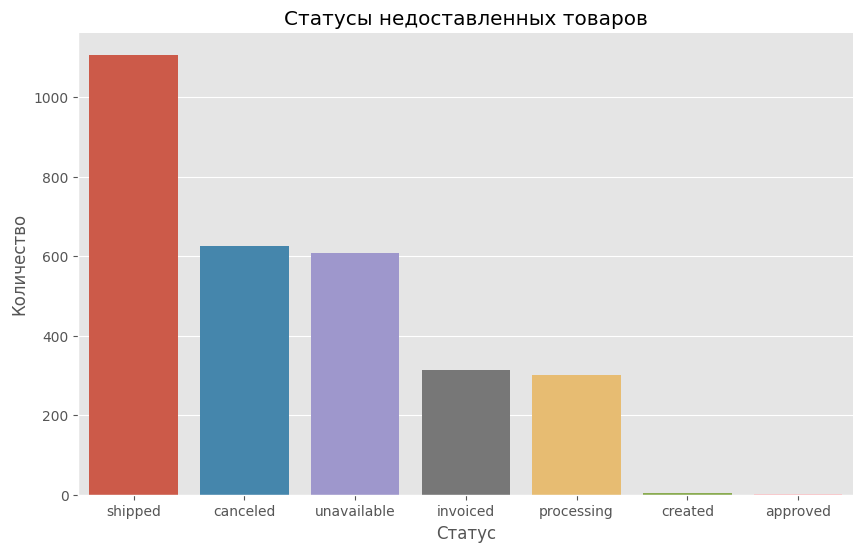

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=status.sort_values('total', ascending=False), x='order_status', y='total')
props = {
    'title' : 'Статусы недоставленных товаров',
    'xlabel' : 'Статус',
    'ylabel' : 'Количество'
}
ax.set(**props)
sns.despine()

Статусы 'invoiced', 'processing', 'created' и 'approved' не подходят, т.к. находятся на начальной стадии заказа 
и еще не отправлены. Заказ со статусом 'shipped' находится в стадии доставки и не может считаться не доставленным.
Остаются заказы со статусами 'canceled' и 'unavailable' они удовлетворяют условию.

Text(0, 0.5, 'Количество')

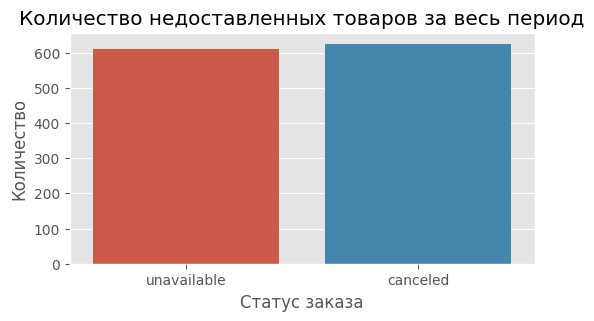

In [20]:
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot(data=orders.loc[orders['order_status'].isin(['unavailable', 'canceled'])], x='order_status')
ax.set_title('Количество недоставленных товаров за весь период')
ax.set_xlabel('Статус заказа')
ax.set_ylabel('Количество')

In [21]:
not_delivered = orders.loc[orders['order_status'].isin(['unavailable', 'canceled'])]
not_delivered['order_estimated_delivery_date'] = pd.to_datetime(not_delivered['order_estimated_delivery_date'])
not_delivered['estimated_delivery'] = not_delivered['order_estimated_delivery_date']\
    .apply(lambda x : x.strftime('%Y-%m'))
not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_delivery
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05,2017-12
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaN,NaN,2018-08-14,2018-08
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16,2018-02
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22,2018-02
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05,2017-09


In [22]:
not_delivered_monthly = not_delivered\
    .groupby(['order_status', 'estimated_delivery'], as_index=False)\
    .agg(total=('order_id', 'count'))
not_delivered_monthly    

,order_status,estimated_delivery,total
0,canceled,2016-09,1
1,canceled,2016-10,3
2,canceled,2016-11,14
3,canceled,2016-12,8
4,canceled,2017-02,2
5,canceled,2017-03,26
6,canceled,2017-04,22
7,canceled,2017-05,23
8,canceled,2017-06,29
9,canceled,2017-07,21


In [23]:
not_delivered_monthly_mean = not_delivered_monthly[['order_status', 'total']]\
    .groupby('order_status', as_index=False)\
    .mean().round(2)
not_delivered_monthly_mean

,order_status,total
0,canceled,24.04
1,unavailable,29.00


В среднем в месяц не доставляется заказов:
- 24.04 - по причине отмены;
- 29.00 - статус недоступен.

# 3.По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [24]:
products = orders.merge(order_items, on='order_id')[['product_id', 'order_purchase_timestamp']]
products.head()

,product_id,order_purchase_timestamp
0,87285b34884572647811a353c7ac498a,2017-10-02 10:56:33
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-24 20:41:37
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:38:49
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:28:06
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 21:18:39


In [25]:
products['order_purchase_timestamp'] = pd.to_datetime(products['order_purchase_timestamp'])
products['weekday'] = products['order_purchase_timestamp'].dt.day_name()
products.head()

,product_id,order_purchase_timestamp,weekday
0,87285b34884572647811a353c7ac498a,2017-10-02 10:56:33,Monday
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-24 20:41:37,Tuesday
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:38:49,Wednesday
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:28:06,Saturday
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 21:18:39,Tuesday


In [26]:
product_per_day = products\
    .groupby(['product_id', 'weekday'], as_index=False)\
    .agg(total=('order_purchase_timestamp', 'count'))
product_per_day.sort_values('total', ascending=False).head()

,product_id,weekday,total
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


In [27]:
product_per_day.product_id.nunique()

32951

In [28]:
product_per_day.pivot(index='product_id', columns='weekday', values='total') \
            .idxmax(axis=1) \
            .to_frame() \
            .reset_index() \
            .rename(columns={0:'most_popular_day'})

,product_id,most_popular_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


In [29]:
product_per_day.pivot(index='product_id', columns='weekday', values='total')\
    .idxmax(axis=1).to_frame().reset_index().rename(columns={0:'most_popular_day'})

,product_id,most_popular_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


# 4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

Выберем тех клиентов, которые совершили покупки

In [30]:
customers_orders = orders\
    .query("order_status == 'delivered'")\
    .merge(customers, on='customer_id')[['customer_unique_id', 'order_purchase_timestamp', 'order_status']]
customers_orders['order_purchase_timestamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])
customers_orders.head()
    

,customer_unique_id,order_purchase_timestamp,order_status
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,delivered
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,delivered
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,delivered
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,delivered
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,delivered


Посчитаем сколько заказов делает каждый клиент за месяц

In [31]:
customers_orders['date'] = customers_orders['order_purchase_timestamp'].dt.strftime('%Y-%m')
customers_orders

,customer_unique_id,order_purchase_timestamp,order_status,date
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,delivered,2017-10
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,delivered,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,delivered,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,delivered,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,delivered,2018-02
...,...,...,...,...
96473,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,delivered,2017-03
96474,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,delivered,2018-02
96475,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,delivered,2017-08
96476,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,delivered,2018-01


In [32]:
customers_orders = customers_orders\
    .groupby(['customer_unique_id', 'date'], as_index=False)\
    .agg(orders_per_month=('order_status', 'count'))
customers_orders.head()

,customer_unique_id,date,orders_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


Посчитаем сколько недель в каждом месяце

In [33]:
customers_orders['date'] = pd.to_datetime(customers_orders['date'])
customers_orders['week_in_month'] = customers_orders['date'].dt.daysinmonth / 7
customers_orders.head()

,customer_unique_id,date,orders_per_month,week_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,4.285714


Посчитаем сколько в среднем заказов в неделю делает каждый клинент в месяц

In [34]:
customers_orders['orders_per_week'] = customers_orders['orders_per_month'] / customers_orders['week_in_month']
customers_orders[['customer_unique_id', 'orders_per_week']]

,customer_unique_id,orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333
...,...,...
95189,fffcf5a5ff07b0908bd4e2dbc735a684,0.233333
95190,fffea47cd6d3cc0a88bd621562a9d061,0.225806
95191,ffff371b4d645b6ecea244b27531430a,0.250000
95192,ffff5962728ec6157033ef9805bacc48,0.225806


# 5.Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [35]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [36]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Сформируем рабочий датафрейм, соединив два исходных 'customers' и 'orders' и откинув ненужные колонки.

In [37]:
df = orders.merge(customers, how='left', on='customer_id')[['customer_unique_id', 'order_purchase_timestamp']]
df = df.rename(columns={'customer_unique_id' : 'customer_id', 'order_purchase_timestamp' : 'order_date'})
df['order_date'] = pd.to_datetime(df['order_date'])
df.head()

,customer_id,order_date
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


Определим дату первой покупки для каждого пользователя.

In [38]:
df['start_day'] = df.groupby('customer_id')['order_date'].transform('min').dt.date
df.head()

,customer_id,order_date,start_day
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09-04
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13


Определим месяц, в который пользователи совершили свою первую покупку.

In [39]:
df['start_month'] = df['start_day'].values.astype('datetime64[M]')
df.head()

,customer_id,order_date,start_day,start_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09-04,2017-09-01
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-24,2018-07-01
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08,2018-08-01
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18,2017-11-01
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13,2018-02-01


Определим, сколько месяцев прошло с момента первой покупки по последующими.

In [40]:
df['months_since_start'] = np.floor((df['order_date'] - df['start_month']) / np.timedelta64(1, 'M')).astype('int8')
df.head()

,customer_id,order_date,start_day,start_month,months_since_start
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09-04,2017-09-01,1
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-24,2018-07-01,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08,2018-08-01,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18,2017-11-01,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13,2018-02-01,0


Определим когорты.

In [41]:
cohort_data = df.groupby(['start_month', 'months_since_start'])['customer_id'].apply(pd.Series.nunique)
cohort_data.head()

start_month  months_since_start
2016-09-01   0                       4
2016-10-01   0                     321
             6                       1
             9                       1
             11                      1
Name: customer_id, dtype: int64

In [42]:
cohort_data = cohort_data.to_frame().reset_index()

In [43]:
cohort_data = cohort_data.rename(columns={'customer_id' : 'customers'})

Построим сводную таблицу по когортам.

In [44]:
cohort_table = cohort_data.pivot(index='start_month', columns='months_since_start', values='customers')
cohort_table = cohort_table.divide(cohort_table.iloc[:,0], axis=0)
cohort_table 

months_since_start,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
start_month,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12-01,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,1.0,0.086402,0.002833,0.001416,0.004249,0.001416,0.005666,0.001416,0.001416,NaN,0.004249,0.001416,0.008499,0.004249,0.001416,0.001416,0.002833,0.004249,0.001416,NaN
2017-02-01,1.0,0.000571,0.002854,0.001712,0.003425,0.001712,0.002283,0.001142,0.002283,0.001712,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03-01,1.0,0.026346,0.003487,0.004262,0.003487,0.001550,0.001550,0.003100,0.003100,0.001162,0.003874,0.001550,0.002325,0.001162,0.001550,0.002325,0.000775,0.001550,NaN,NaN
2017-04-01,1.0,0.005952,0.002126,0.001701,0.002976,0.002976,0.002976,0.002976,0.003401,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05-01,1.0,0.035827,0.005159,0.004013,0.003153,0.003439,0.004299,0.001720,0.002293,0.003439,0.002580,0.003439,0.002293,0.000573,0.002006,0.002580,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.001911,0.001911,0.001911,0.003504,0.003186,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


Сделаем визуализацию.

[Text(0.5, 1.0, 'Retention rate'),
 Text(0.5, 102.72222222222219, 'Month since start'),
 Text(220.72222222222223, 0.5, 'Join months')]

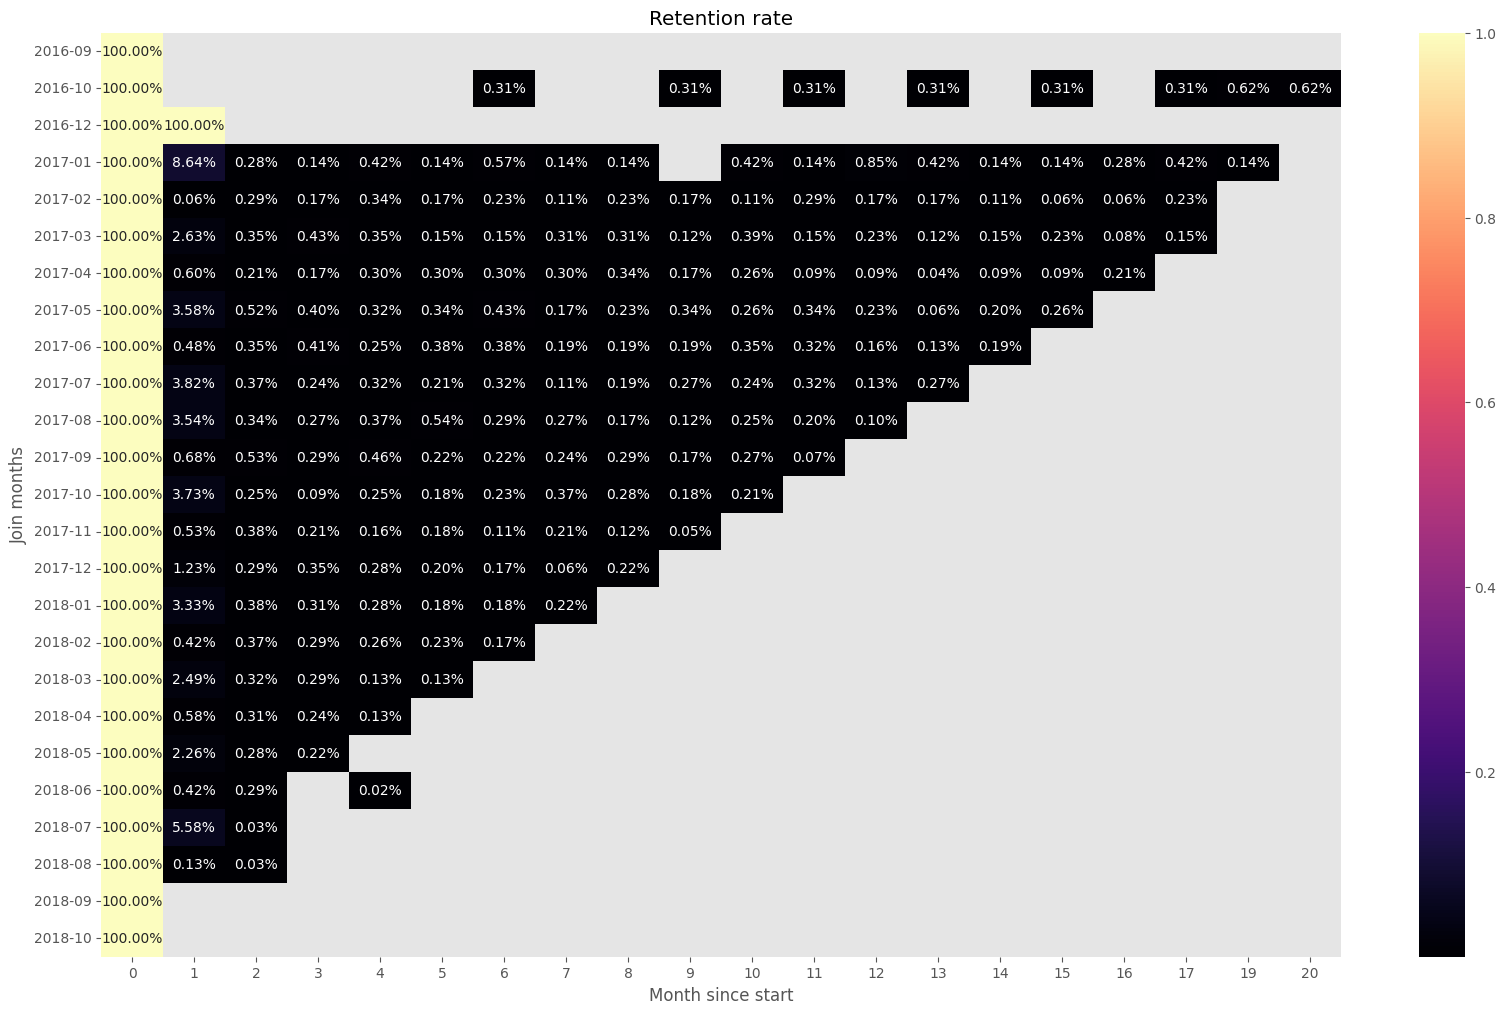

In [47]:
#cohort_table.index = cohort_table.index.strftime('%Y-%m')
fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.heatmap(cohort_table, annot=True, cmap='magma', fmt='.2%')
props = {
    'title' : 'Retention rate',
    'xlabel' : 'Month since start',
    'ylabel' : 'Join months'
}
ax.set(**props)

Самый высокий 'retention rate' у когорты '2017-06'.

# 6. Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M.

## Подготовим данные

In [48]:
cust_orders = customers.merge(orders, on='customer_id')
cust_orders = cust_orders.merge(order_items)[['customer_unique_id', 'price', 'order_purchase_timestamp', 'order_id', 'order_status']]
cust_orders = cust_orders.query('order_status not in ("canceled", \
                                                      "unavailable", \
                                                      "invoiced", \
                                                      "processing", \
                                                      "created", \
                                                      "approved", \
                                                      "shipped")')
cust_orders.head()

,customer_unique_id,price,order_purchase_timestamp,order_id,order_status
0,861eff4711a542e4b93843c6dd7febb0,124.99,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,delivered
1,290c77bc529b7ac935b93aa66c333dc3,289.00,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,139.94,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered
3,259dac757896d24d7702b9acbbff3f3c,149.94,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba,delivered
4,345ecd01c38d18a9036ed96c73b8d066,230.00,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered


In [49]:
cust_orders = cust_orders.rename(columns={'customer_unique_id' : 'customer_id', 
                                         'order_purchase_timestamp' : 'order_date'})
cust_orders.head()

,customer_id,price,order_date,order_id,order_status
0,861eff4711a542e4b93843c6dd7febb0,124.99,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,delivered
1,290c77bc529b7ac935b93aa66c333dc3,289.00,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,139.94,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered
3,259dac757896d24d7702b9acbbff3f3c,149.94,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba,delivered
4,345ecd01c38d18a9036ed96c73b8d066,230.00,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered


In [50]:
cust_orders.shape[0]

110197

In [51]:
cust_orders['order_date'] = pd.to_datetime(cust_orders['order_date'])

В качестве даты, относительно которой пойдет отсчет, будем считать дату последней покупки + 1 день.

In [52]:
now_date = cust_orders.order_date.max() + dt.timedelta(days=1)
now_date

Timestamp('2018-08-30 15:00:37')

## Посчитаем все необходимые метрики

Recency - дельта, которая показывает, когда была совершена последняя покупка.

Frequency - считаем число заказов на одного пользователя.

Monetary - считаем суммарную сумму, потраченную пользователем.


In [53]:
recency = cust_orders\
    .groupby('customer_id', as_index=False)\
    .agg({'order_date' : lambda x : (now_date - x.max()).days})\
    .rename(columns={'order_date' : 'recency'})
recency.head()

,customer_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115
2,0000f46a3911fa3c0805444483337064,537
3,0000f6ccb0745a6a4b88665a16c9f078,321
4,0004aac84e0df4da2b147fca70cf8255,288


In [54]:
frequency = cust_orders\
    .groupby('customer_id', as_index=False)\
    .agg({'order_id' : 'count'})\
    .rename(columns={'order_id' : 'frequency'})
frequency.head()

,customer_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [55]:
monetary = cust_orders\
    .groupby('customer_id', as_index=False)\
    .agg({'price' : 'sum'})\
    .rename(columns={'price' : 'monetary'})
monetary.head()

,customer_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


Объединим все в один датафрейм для RFM-анализа.

In [56]:
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')
rfm.head()

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


Визуализируем и изучим отдельно каждую метрику.

## Recency

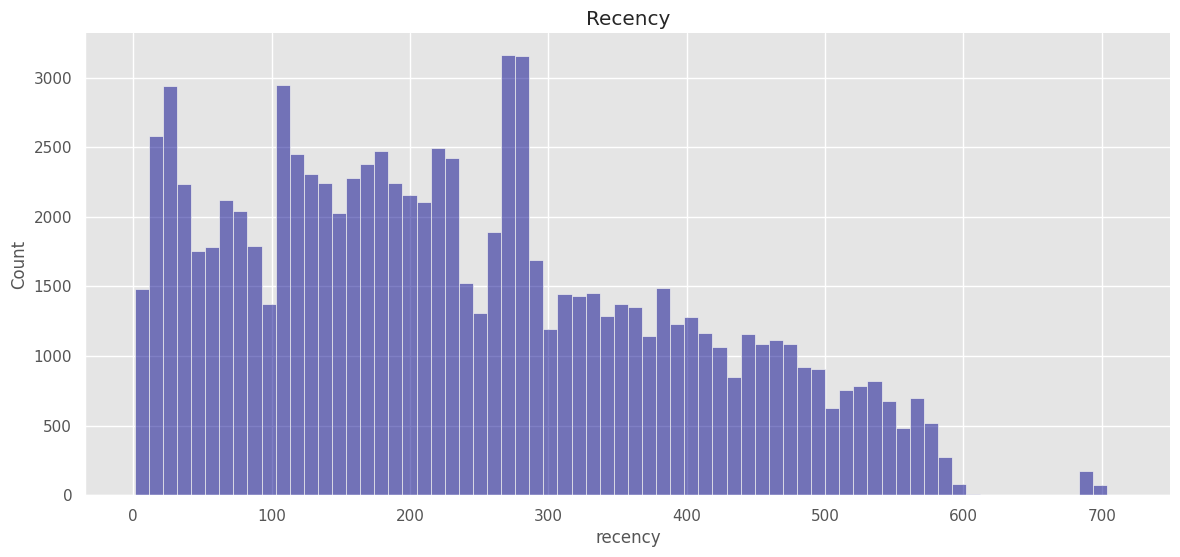

In [86]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=rfm.recency, color='darkblue', alpha=0.5)
ax.set_title('Recency')
sns.despine()

In [58]:
print(rfm.recency.quantile(q=.33))
print(rfm.recency.quantile(q=.66))

147.0
286.0


Разобъем Recency на три периода. Последний будет лежать за отметкой в 286 дня, как показал нам квантиль=0.66, граница первого закончится на границе квантиля в 0.33.


In [59]:
def R(recency):
    if recency <= 147:
        return 3
    elif 147 < recency <= 286:
        return 2
    else:
        return 1

In [60]:
rfm['r'] = rfm.recency.apply(R)
rfm.head()

,customer_id,recency,frequency,monetary,r
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1


## Frequency

In [61]:
print(rfm.frequency.value_counts().to_list()[0] / sum(rfm.frequency.value_counts().to_list()[:]) * 100)

87.56400094260802


Почти 88% покупателей совершили только одну покупку.

Разобьем Frequency также на 3 группы:
- 1 - 1 покупка; 
- 2 - 2 покупки; 
- 3 - 3 покупки и более

In [62]:
def F(frequency):
    if frequency == 1:
        return 1
    elif frequency == 2:
        return 2
    else:
        return 3

In [63]:
rfm['f'] = rfm.frequency.apply(F)
rfm.head()

,customer_id,recency,frequency,monetary,r,f
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1


## Monetary

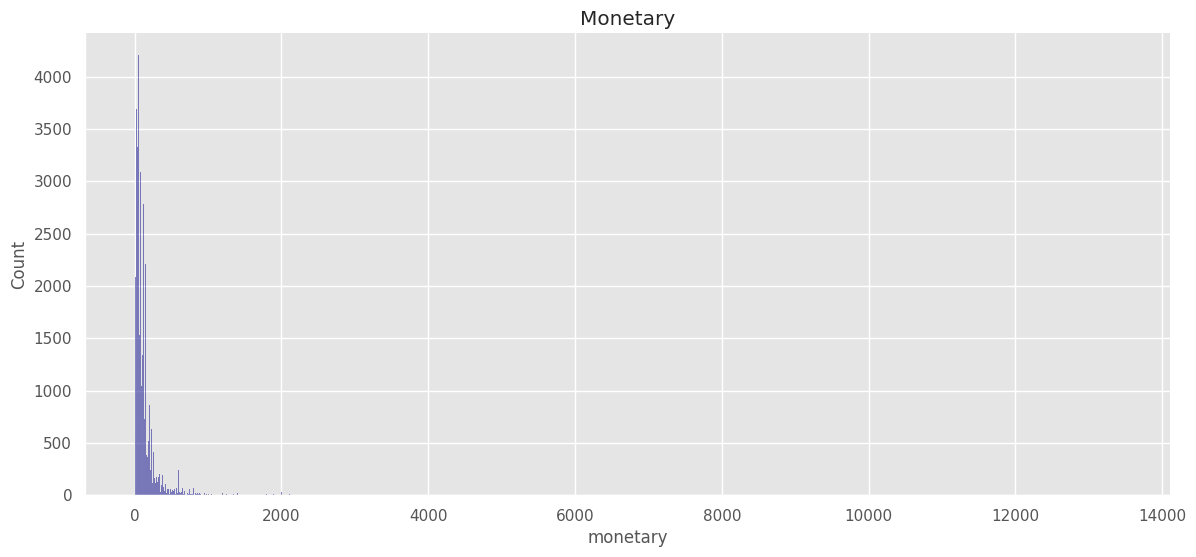

In [87]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(rfm.monetary, color='darkblue', alpha=0.5)
ax.set_title('Monetary')
sns.despine()

In [65]:
rfm.monetary.describe()

count    93358.000000
mean       141.621480
std        215.694014
min          0.850000
25%         47.650000
50%         89.730000
75%        154.737500
max      13440.000000
Name: monetary, dtype: float64

Также разобьем Monetary на 3 группы:
- 1 - тратят до 100 у.е; 
- 2 - тратят от 100 до 1000 у.е; 
- 3 - тратят 1000 у.е. и более 

In [66]:
def M(monetary):
    if monetary < 100:
        return 1
    elif 100 <= monetary < 1000:
        return 2
    else: 
        return 3

In [67]:
rfm['m'] = rfm.monetary.apply(M)
rfm.head()

,customer_id,recency,frequency,monetary,r,f,m
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,2


## Получим результирующую таблицу с разбивкой на кластеры RFM и сделаем визуализацию

In [68]:
rfm['RFM'] = rfm['r'].astype('str') + rfm['f'].astype('str') + rfm['m'].astype('str')
rfm.head()

,customer_id,recency,frequency,monetary,r,f,m,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,2,112


Для каждого кластера выведем средние значения

In [69]:
rfm_groupped = rfm\
    .groupby('RFM', as_index=False)\
    .agg({'recency' : 'mean', 'frequency' : 'mean', 'monetary' : 'mean'}).round(2)
rfm_groupped.head()

,RFM,recency,frequency,monetary
0,111,415.84,1.0,53.17
1,112,416.59,1.0,227.83
2,113,413.14,1.0,1603.14
3,121,417.97,2.0,62.09
4,122,408.94,2.0,232.93


In [70]:
rfm_groupped.value_counts().count()

27

In [71]:
rfm_num_customers = rfm\
    .groupby('RFM', as_index=False)\
    .agg(num_of_customers=('customer_id', 'count'))
rfm_num_customers.head()

,RFM,num_of_customers
0,111,17301
1,112,10261
2,113,285
3,121,1169
4,122,1758


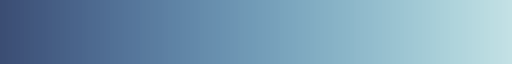

In [72]:
sns.color_palette("ch:r=-.2,d=.3_r", as_cmap=True)

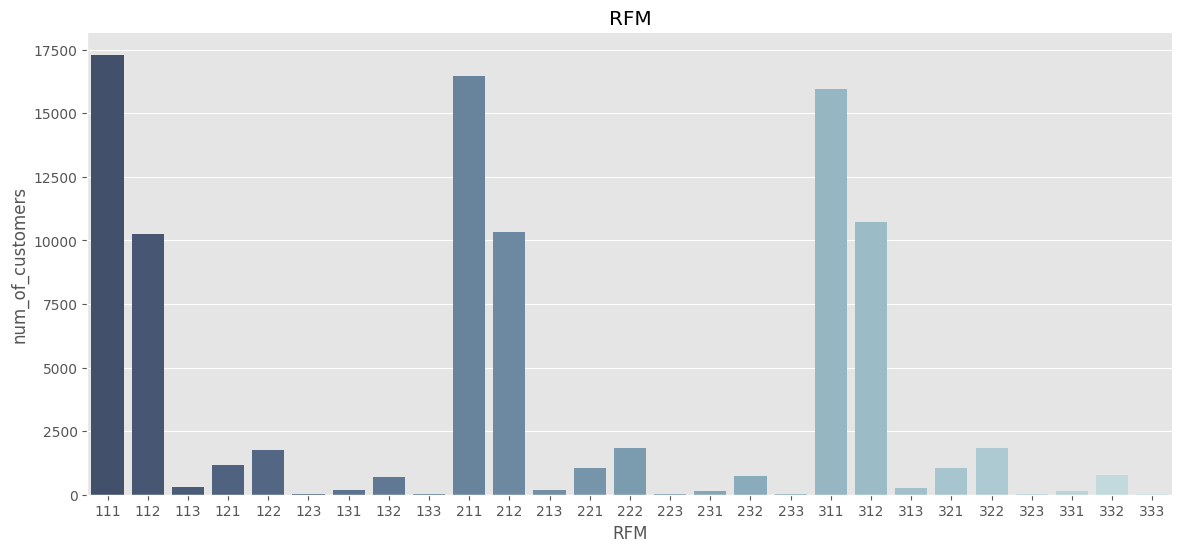

In [73]:
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(data=rfm_num_customers, x='RFM', y='num_of_customers', palette="ch:r=-.2,d=.3_r")
ax.set_title('RFM')
sns.despine()